# Jan 4th, 2022 (Coreg ses)

**Motivation**: Co-register 3 sessions together: finalize. <br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from myterial import orange, blue_grey
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')
%matplotlib inline

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = pjoin(os.environ['HOME'], 'Documents/workspaces/lfr/binary_overlapping')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.fourier import *
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
# HIDE CODE


def _coronal(key, obj, t1w, figsize=(13.5, 16)):
    slices = range(21, 66, 4)

    fig, axes = create_figure(4, 3, figsize)
    for i, idx in enumerate(slices):
        ax = axes.flat[i]
        x2plt = np.ma.masked_where(~obj.astype(bool), obj)
        ax.imshow(t1w[..., idx].T, cmap='bone')
        ax.imshow(x2plt[..., idx].T, alpha=1.0, cmap=cmap)
        ax.set_title(f"slice #{idx}")
    sup = fig.suptitle(f"{key}  .  .  .  Coronal", fontsize=17, y=1.02)
    remove_ticks(axes)
    plt.close()
    
    return fig, sup


def _sagittal(key, obj, t1w, figsize=(13.5, 12)):
    slices = range(2, 48, 4)

    fig, axes = create_figure(4, 3, figsize)
    for i, idx in enumerate(slices):
        ax = axes.flat[i]
        x2plt = np.ma.masked_where(~obj.astype(bool), obj)
        ax.imshow(t1w[idx], cmap='bone')
        ax.imshow(x2plt[idx], alpha=1.0, cmap=cmap)
        ax.set_title(f"slice #{idx}")
    sup = fig.suptitle(f"{key}  .  .  .  Sagittal", fontsize=17, y=1.02)
    remove_ticks(axes)
    plt.close()
    
    return fig, sup


def _axial(key, obj, t1w, figsize=(13.5, 13)):
    slices = range(2, 25, 2)

    fig, axes = create_figure(4, 3, figsize)
    for i, idx in enumerate(slices):
        ax = axes.flat[i]
        x2plt = np.ma.masked_where(~obj.astype(bool), obj)
        ax.imshow(t1w[:, idx, :], cmap='bone')
        ax.imshow(x2plt[:, idx, :], alpha=1.0, cmap=cmap)
        ax.set_title(f"slice #{idx}")
    sup = fig.suptitle(f"{key}  .  .  .  Axial", fontsize=17, y=1.02)
    remove_ticks(axes)
    plt.close()
    
    return fig, sup

In [3]:
mice = Mice((64, 0, 100), load_parcel=True, load_allen=True, full_load=True)

ROI lookup not found, time to run organize_func() . . .

combine metadata not found, time to run cat_data() . . .

In [4]:
# Get stuff from Parcel

cortex = mice.parcel['cortex']
regions = cortex[cortex.nonzero()]
regions = np.unique(regions)
hcl = mice.parcel.decode(regions)


# Random CMAP
rng = get_rng()
num = len(mice.parcel['regions-cortex'])
colors = (
    rng.choice(256, size=num) / 256,
    rng.choice(256, size=num) / 256,
    rng.choice(256, size=num) / 256,
)
colors = list(zip(*colors))
colors = [rgb2hex(c) for c in colors]
cmap = make_cmap(
    ramp_colors=colors,
    name='random_cmap',
    n_colors=num,
    show=False,
)

## ---

In [5]:
# HIDE CODE


obj_files = sorted([
    str(e) for e in
    pathlib.Path(mice.cfg.masks_dir).rglob('*_cortex.nii.gz*')
])
objs, t1ws, masks = {}, {}, {}
for key, anat in mice.T1w.items():
    file = next(
        f for f in obj_files
        if key in f
    )
    objs[key] = ants.image_read(
        pjoin(mice.cfg.masks_dir, file),
        pixeltype='unsigned int',
    ).numpy()
    t1ws[key] = anat.load_ants().numpy()
    masks[key] = mice.mask3d[key].load_ants().numpy()

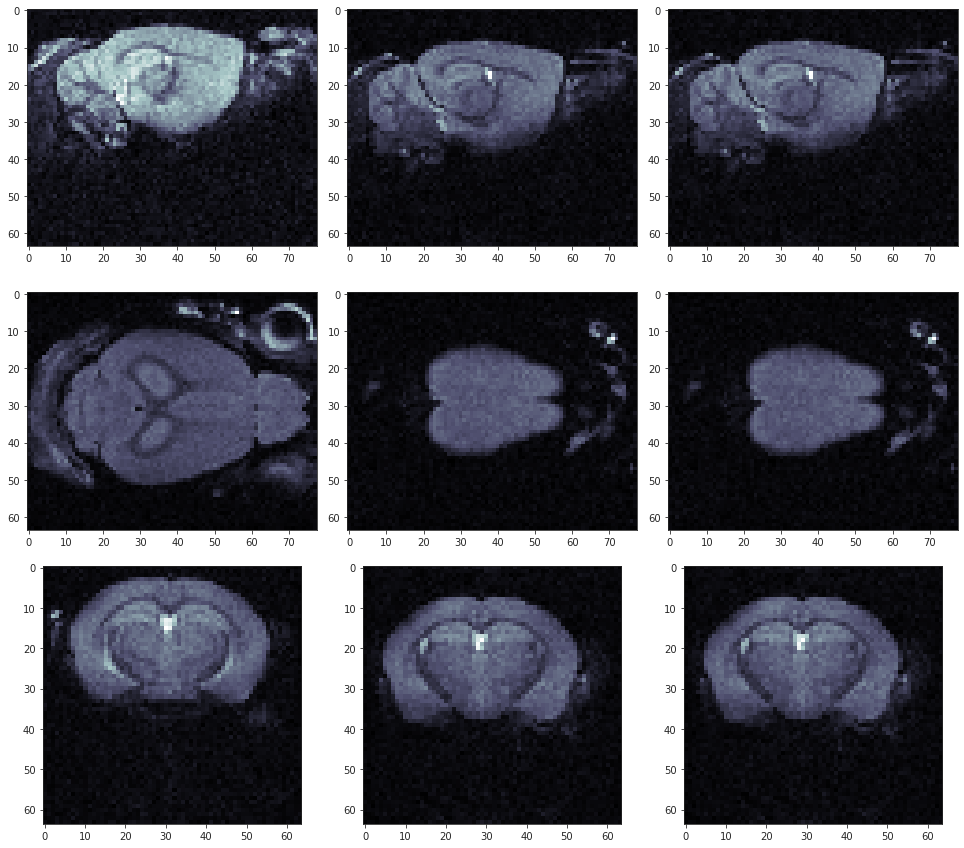

In [6]:
fig, axes = create_figure(3, 3, (13.5, 12))

keys = ['sub-SLC10_ses-1', 'sub-SLC10_ses-2', 'sub-SLC10_ses-3']
slices = [18, 10, 35]

for j, slice_idx in enumerate(slices):
    for i, ax in enumerate(axes[j].flat):
        x2plt = np.take(t1ws[keys[i]], slice_idx, axis=j)
        if j == 2:
            x2plt = x2plt.T
        ax.imshow(x2plt, cmap='bone')

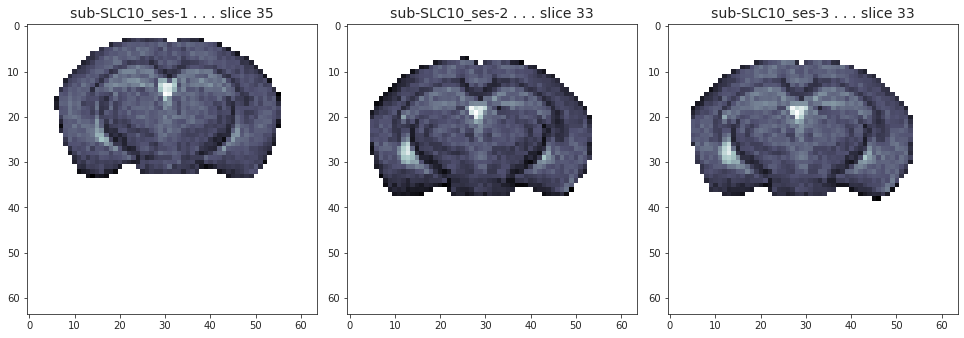

In [7]:
fig, axes = create_figure(1, 3, (13.5, 12))

slices = [35, 33, 33]
for i, ax in enumerate(axes.flat):
    m = np.take(masks[keys[i]], slices[i], axis=2)
    x2plt = np.take(t1ws[keys[i]], slices[i], axis=2)
    x2plt = np.ma.masked_where(~m.astype(bool), x2plt)
    x2plt = x2plt.T
    ax.imshow(x2plt, cmap='bone')
    ax.set_title(f"{keys[i]} . . . slice {slices[i]}", fontsize=14)

In [8]:
from register.register import reset_ants_img

x1 = mice.T1w[keys[0]].load_ants() * mice.mask3d[keys[0]].load_ants()
x2 = mice.T1w[keys[1]].load_ants() * mice.mask3d[keys[1]].load_ants()
x3 = mice.T1w[keys[2]].load_ants() * mice.mask3d[keys[2]].load_ants()

x1

ANTsImage (RAI)
         Pixel Type : float (float32)
         Components : 1
         Dimensions : (64, 64, 78)
         Spacing    : (0.2, 0.2, 0.2)
         Origin     : (6.4, -6.2, -7.8)
         Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

<matplotlib.colorbar.Colorbar object at 0x7e517175d610>

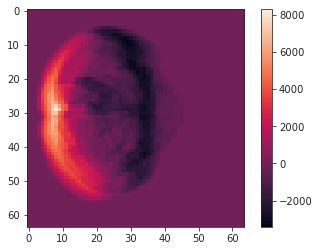

In [9]:
plt.imshow(x1.mean(-1) - x2.mean(-1))
plt.colorbar()

In [10]:
base_mi = ants.image_mutual_information(x1, x1)
mi = ants.image_mutual_information(x1, x2)
mi /= base_mi

mi

0.34755291933960414

In [11]:
txfile = ants.affine_initializer(
    fixed_image=x1,
    moving_image=x2,
    search_factor=5,
)
tx_aff = ants.read_transform(
    filename=txfile, dimension=3)
x2_aff = tx_aff.apply_to_image(
    image=x2,
    reference=x1,
    interpolation='linear',
)

mi = ants.image_mutual_information(
    image1=x2_aff, image2=x1)
mi /= base_mi
mi

0.7658809405219725

In [12]:
txfile = ants.affine_initializer(
    fixed_image=x1,
    moving_image=x3,
    search_factor=5,
)
tx_aff = ants.read_transform(
    filename=txfile, dimension=3)
x3_aff = tx_aff.apply_to_image(
    image=x3,
    reference=x1,
    interpolation='linear',
)

mi = ants.image_mutual_information(
    image1=x3_aff, image2=x1)
mi /= base_mi
mi

0.7697679795295318

In [13]:
tx = ants.registration(
    fixed=x1,
    moving=x2,
    type_of_transform='Rigid',
    random_seed=0,
    verbose=False,
)
x2_rig = tx.get('warpedmovout', None)

mi = ants.image_mutual_information(
    image1=x2_rig, image2=x1)
mi /= base_mi
mi

0.7746771905032178

In [14]:
tx = ants.registration(
    fixed=x1,
    moving=x3,
    type_of_transform='Rigid',
    random_seed=0,
    verbose=False,
)
x3_rig = tx.get('warpedmovout', None)

mi = ants.image_mutual_information(
    image1=x3_rig, image2=x1)
mi /= base_mi
mi

0.7772961447061221

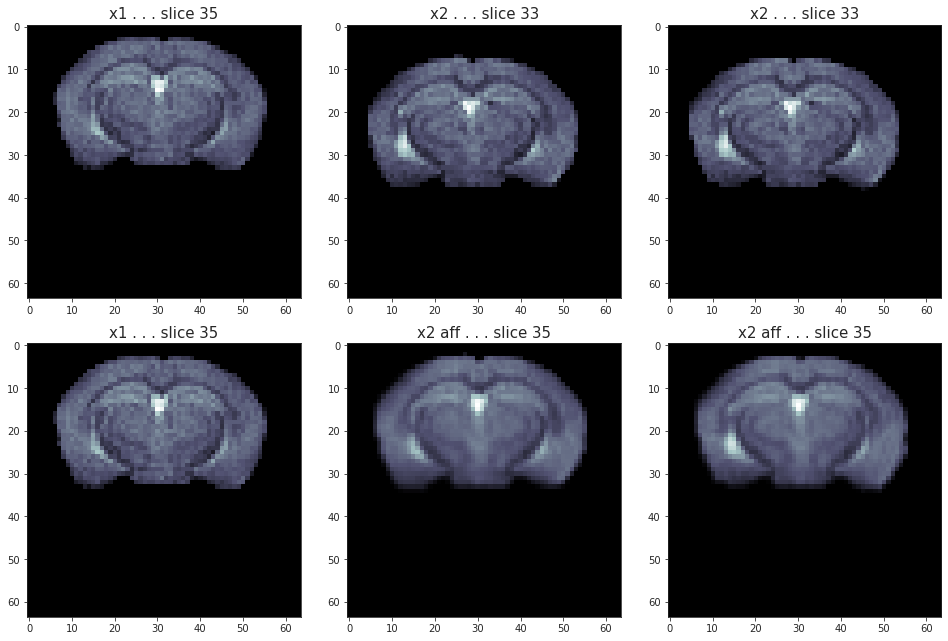

In [15]:
fig, axes = create_figure(2, 3, (13.5, 9))
slices = [35, 33, 33]
x2plt = x1[..., slices[0]].T
axes[0, 0].imshow(x2plt, cmap='bone')
x2plt = x2[..., slices[1]].T
axes[0, 1].imshow(x2plt, cmap='bone')
x2plt = x3[..., slices[2]].T
axes[0, 2].imshow(x2plt, cmap='bone')

axes[0, 0].set_title(f"x1 . . . slice {slices[0]}", fontsize=15)
axes[0, 1].set_title(f"x2 . . . slice {slices[1]}", fontsize=15)
axes[0, 2].set_title(f"x2 . . . slice {slices[2]}", fontsize=15)

x2plt = x1[..., slices[0]].T
axes[1, 0].imshow(x2plt, cmap='bone')
x2plt = x2_aff[..., slices[0]].T
axes[1, 1].imshow(x2plt, cmap='bone')
x2plt = x3_aff[..., slices[0]].T
axes[1, 2].imshow(x2plt, cmap='bone')

axes[1, 0].set_title(f"x1 . . . slice {slices[0]}", fontsize=15)
axes[1, 1].set_title(f"x2 aff . . . slice {slices[0]}", fontsize=15)
axes[1, 2].set_title(f"x2 aff . . . slice {slices[0]}", fontsize=15)

plt.show()

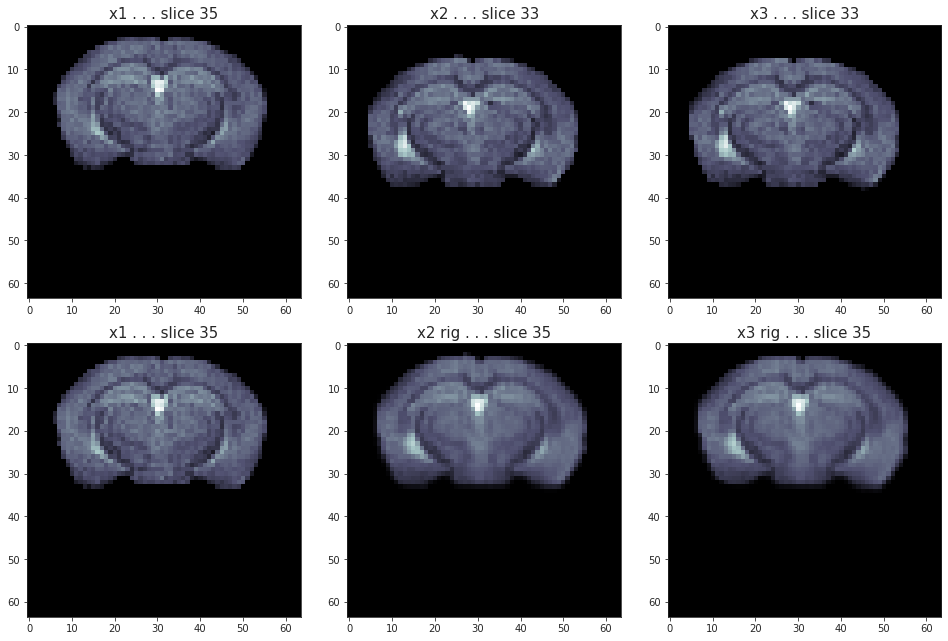

In [16]:
fig, axes = create_figure(2, 3, (13.5, 9))
slices = [35, 33, 33]
x2plt = x1[..., slices[0]].T
axes[0, 0].imshow(x2plt, cmap='bone')
x2plt = x2[..., slices[1]].T
axes[0, 1].imshow(x2plt, cmap='bone')
x2plt = x3[..., slices[2]].T
axes[0, 2].imshow(x2plt, cmap='bone')

axes[0, 0].set_title(f"x1 . . . slice {slices[0]}", fontsize=15)
axes[0, 1].set_title(f"x2 . . . slice {slices[1]}", fontsize=15)
axes[0, 2].set_title(f"x3 . . . slice {slices[2]}", fontsize=15)

x2plt = x1[..., slices[0]].T
axes[1, 0].imshow(x2plt, cmap='bone')
x2plt = x2_rig[..., slices[0]].T
axes[1, 1].imshow(x2plt, cmap='bone')
x2plt = x3_rig[..., slices[0]].T
axes[1, 2].imshow(x2plt, cmap='bone')

axes[1, 0].set_title(f"x1 . . . slice {slices[0]}", fontsize=15)
axes[1, 1].set_title(f"x2 rig . . . slice {slices[0]}", fontsize=15)
axes[1, 2].set_title(f"x3 rig . . . slice {slices[0]}", fontsize=15)


plt.show()

## Register CCF --> Indiv (10x)
Followed by 2x intra-session rigid transformations

In [5]:
from register.register import Register
reg = Register(mice)

In [6]:
save_results = False

In [7]:
ses_fx = 2
obj_all = {}
for sub in tqdm(mice.cfg.sub_ids):
    key_fx = mice.get_key(sub, ses_fx)
    fx = mice.T1w[key_fx].load_ants()
    fx *= mice.mask3d[key_fx].load_ants()
    fx_prep = reg._prepare(fx)
    base_mi = ants.image_mutual_information(
        image1=fx, image2=fx)

    # Load or perform CCF --> Selected ses
    tx, tx_aff = reg.load_tx(key_fx)
    if not tx:
        results = reg.fit_register(
            name=key_fx,
            moving=fx_prep,
            fixed=reg.nissl,
            save_results=True,
        )
    tx, tx_aff = reg.load_tx(key_fx)

    affined = tx_aff.apply_to_image(
        image=fx_prep,
        reference=reg.nissl,
        interpolation='linear',
    )
    obj = reg._apply_tx_obj2lps(
        name=key_fx,
        moving=affined,
        moving_orig=fx_prep,
        tx_aff=tx_aff,
        tx=tx,
        use_mm=True,
        save_results=save_results,
    )
    obj_all[key_fx] = obj

    for ses_mv in [j for j in mice.cfg.ses_ids if j != ses_fx]:
        key_mv = mice.get_key(sub, ses_mv)
        mv = mice.T1w[key_mv].load_ants()
        mv *= mice.mask3d[key_mv].load_ants()

        tx_rig = ants.registration(
            fixed=mv,
            moving=fx,
            type_of_transform='Rigid',
            verbose=False,
        )
        obj_all[key_mv] = {
            k: ants.apply_transforms(
                fixed=mv,
                moving=o,
                transformlist=tx_rig['fwdtransforms'],
                interpolator='genericLabel',
            ) for k, o in obj.items()
        }

        mi = ants.image_mutual_information(
            image1=fx, image2=tx_rig['warpedfixout'])
        mi /= base_mi
        print(f"sub = {sub}  . . .  ses_fx/mv = {ses_fx}/{ses_mv} \t perf = {mi}")
    print('\n')
    
obj_all = dict(sorted(obj_all.items()))

  0%|          | 0/10 [00:00<?, ?it/s]

sub = 1  . . .  ses_fx/mv = 2/1          perf = 0.7968628815868392

sub = 1  . . .  ses_fx/mv = 2/3          perf = 0.8258243976515193

sub = 2  . . .  ses_fx/mv = 2/1          perf = 0.7800316441171055

sub = 2  . . .  ses_fx/mv = 2/3          perf = 0.8042559050819308

sub = 3  . . .  ses_fx/mv = 2/1          perf = 0.7536336654672691

sub = 3  . . .  ses_fx/mv = 2/3          perf = 0.7756027695282671

sub = 4  . . .  ses_fx/mv = 2/1          perf = 0.7710058552891859

sub = 4  . . .  ses_fx/mv = 2/3          perf = 0.7953963465172205

sub = 5  . . .  ses_fx/mv = 2/1          perf = 0.7702397617058426

sub = 5  . . .  ses_fx/mv = 2/3          perf = 0.7773317491692263

sub = 6  . . .  ses_fx/mv = 2/1          perf = 0.7923353583358841

sub = 6  . . .  ses_fx/mv = 2/3          perf = 0.8071429385684435

sub = 7  . . .  ses_fx/mv = 2/1          perf = 0.7138550847873283

sub = 7  . . .  ses_fx/mv = 2/3          perf = 0.7575573553496735

sub = 8  . . .  ses_fx/mv = 2/1          perf = 0.7124249984166391

sub = 8  . . .  ses_fx/mv = 2/3          perf = 0.7602479932715267

sub = 9  . . .  ses_fx/mv = 2/1          perf = 0.7486791417606709

sub = 9  . . .  ses_fx/mv = 2/3          perf = 0.7875937304606342

sub = 10  . . .  ses_fx/mv = 2/1         perf = 0.7649695947384124

sub = 10  . . .  ses_fx/mv = 2/3         perf = 0.9481306485344245

In [8]:
sub = 4
key_fx = mice.get_key(sub, ses_fx)
fx = mice.T1w[key_fx].load_ants()
fx *= mice.mask3d[key_fx].load_ants()

ses_mv = 3
key_mv = mice.get_key(sub, ses_mv)
mv = mice.T1w[key_mv].load_ants()
mv *= mice.mask3d[key_mv].load_ants()

tx_rig = ants.registration(
    fixed=mv,
    moving=fx,
    type_of_transform='Rigid',
    verbose=False,
)
mv_rig = tx_rig['warpedfixout']

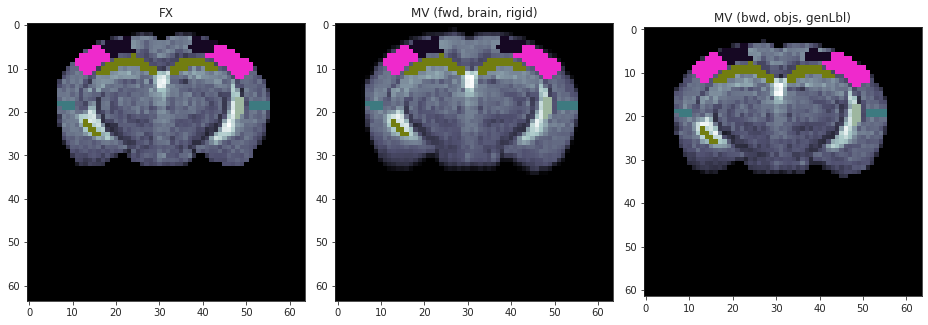

In [9]:
fig, axes = create_figure(1, 3, (13, 5))

ii = 33

axes[0].imshow(fx[..., ii].T, cmap='bone')
x2plt = np.ma.masked_where(
    obj_all[key_fx]['misc'][..., ii] == 0,
    obj_all[key_fx]['misc'][..., ii]
)
axes[0].imshow(x2plt.T, cmap=cmap)
axes[0].set_title('FX')

axes[1].imshow(mv_rig[..., ii].T, cmap='bone')
x2plt = np.ma.masked_where(
    obj_all[key_fx]['misc'][..., ii] == 0,
    obj_all[key_fx]['misc'][..., ii]
)
axes[1].imshow(x2plt.T, cmap=cmap)
axes[1].set_title('MV (fwd, brain, rigid)')


jj = ii + 2

axes[2].imshow(mv[..., jj].T, cmap='bone')
x2plt = np.ma.masked_where(
    obj_all[key_mv]['misc'][..., jj] == 0,
    obj_all[key_mv]['misc'][..., jj]
)
axes[2].imshow(x2plt.T, cmap=cmap)
axes[2].set_title('MV (bwd, objs, genLbl)')
plt.show()

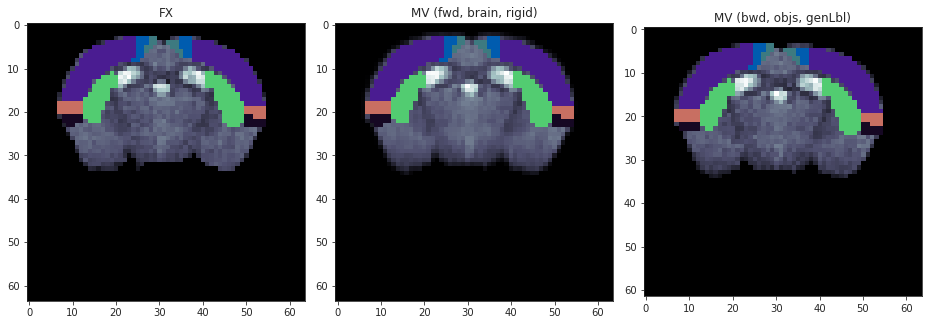

In [11]:
fig, axes = create_figure(1, 3, (13, 5))

ii = 40

axes[0].imshow(fx[..., ii].T, cmap='bone')
x2plt = np.ma.masked_where(
    obj_all[key_fx]['misc'][..., ii] == 0,
    obj_all[key_fx]['misc'][..., ii]
)
axes[0].imshow(x2plt.T, cmap=cmap)
axes[0].set_title('FX')

axes[1].imshow(mv_rig[..., ii].T, cmap='bone')
x2plt = np.ma.masked_where(
    obj_all[key_fx]['misc'][..., ii] == 0,
    obj_all[key_fx]['misc'][..., ii]
)
axes[1].imshow(x2plt.T, cmap=cmap)
axes[1].set_title('MV (fwd, brain, rigid)')


jj = ii + 2

axes[2].imshow(mv[..., jj].T, cmap='bone')
x2plt = np.ma.masked_where(
    obj_all[key_mv]['misc'][..., jj] == 0,
    obj_all[key_mv]['misc'][..., jj]
)
axes[2].imshow(x2plt.T, cmap=cmap)
axes[2].set_title('MV (bwd, objs, genLbl)')
plt.show()

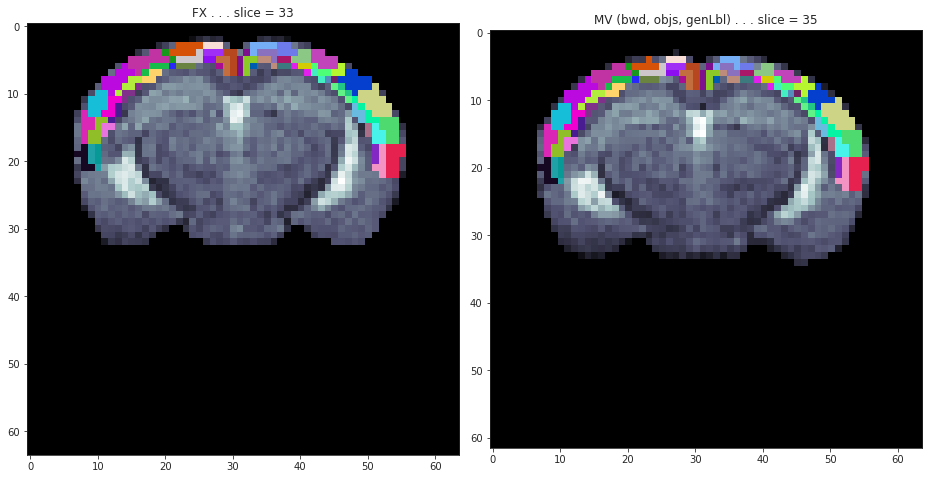

In [18]:
fig, axes = create_figure(1, 2, (13, 8))

ii = 33

axes[0].imshow(fx[..., ii].T, cmap='bone')
x2plt = np.ma.masked_where(
    obj_all[key_fx]['cortex'][..., ii] == 0,
    obj_all[key_fx]['cortex'][..., ii]
)
axes[0].imshow(x2plt.T, cmap=cmap)
axes[0].set_title(f'FX . . . slice = {ii}')

jj = ii + 2

axes[1].imshow(mv[..., jj].T, cmap='bone')
x2plt = np.ma.masked_where(
    obj_all[key_mv]['cortex'][..., jj] == 0,
    obj_all[key_mv]['cortex'][..., jj]
)
axes[1].imshow(x2plt.T, cmap=cmap)
axes[1].set_title(f'MV (bwd, objs, genLbl) . . . slice = {jj}')
plt.show()

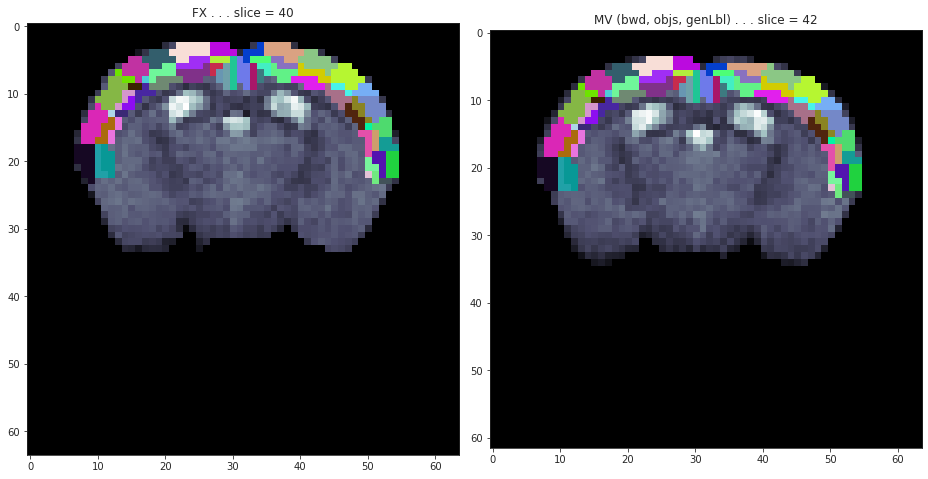

In [19]:
fig, axes = create_figure(1, 2, (13, 8))

ii = 40

axes[0].imshow(fx[..., ii].T, cmap='bone')
x2plt = np.ma.masked_where(
    obj_all[key_fx]['cortex'][..., ii] == 0,
    obj_all[key_fx]['cortex'][..., ii]
)
axes[0].imshow(x2plt.T, cmap=cmap)
axes[0].set_title(f'FX . . . slice = {ii}')

jj = ii + 2

axes[1].imshow(mv[..., jj].T, cmap='bone')
x2plt = np.ma.masked_where(
    obj_all[key_mv]['cortex'][..., jj] == 0,
    obj_all[key_mv]['cortex'][..., jj]
)
axes[1].imshow(x2plt.T, cmap=cmap)
axes[1].set_title(f'MV (bwd, objs, genLbl) . . . slice = {jj}')
plt.show()

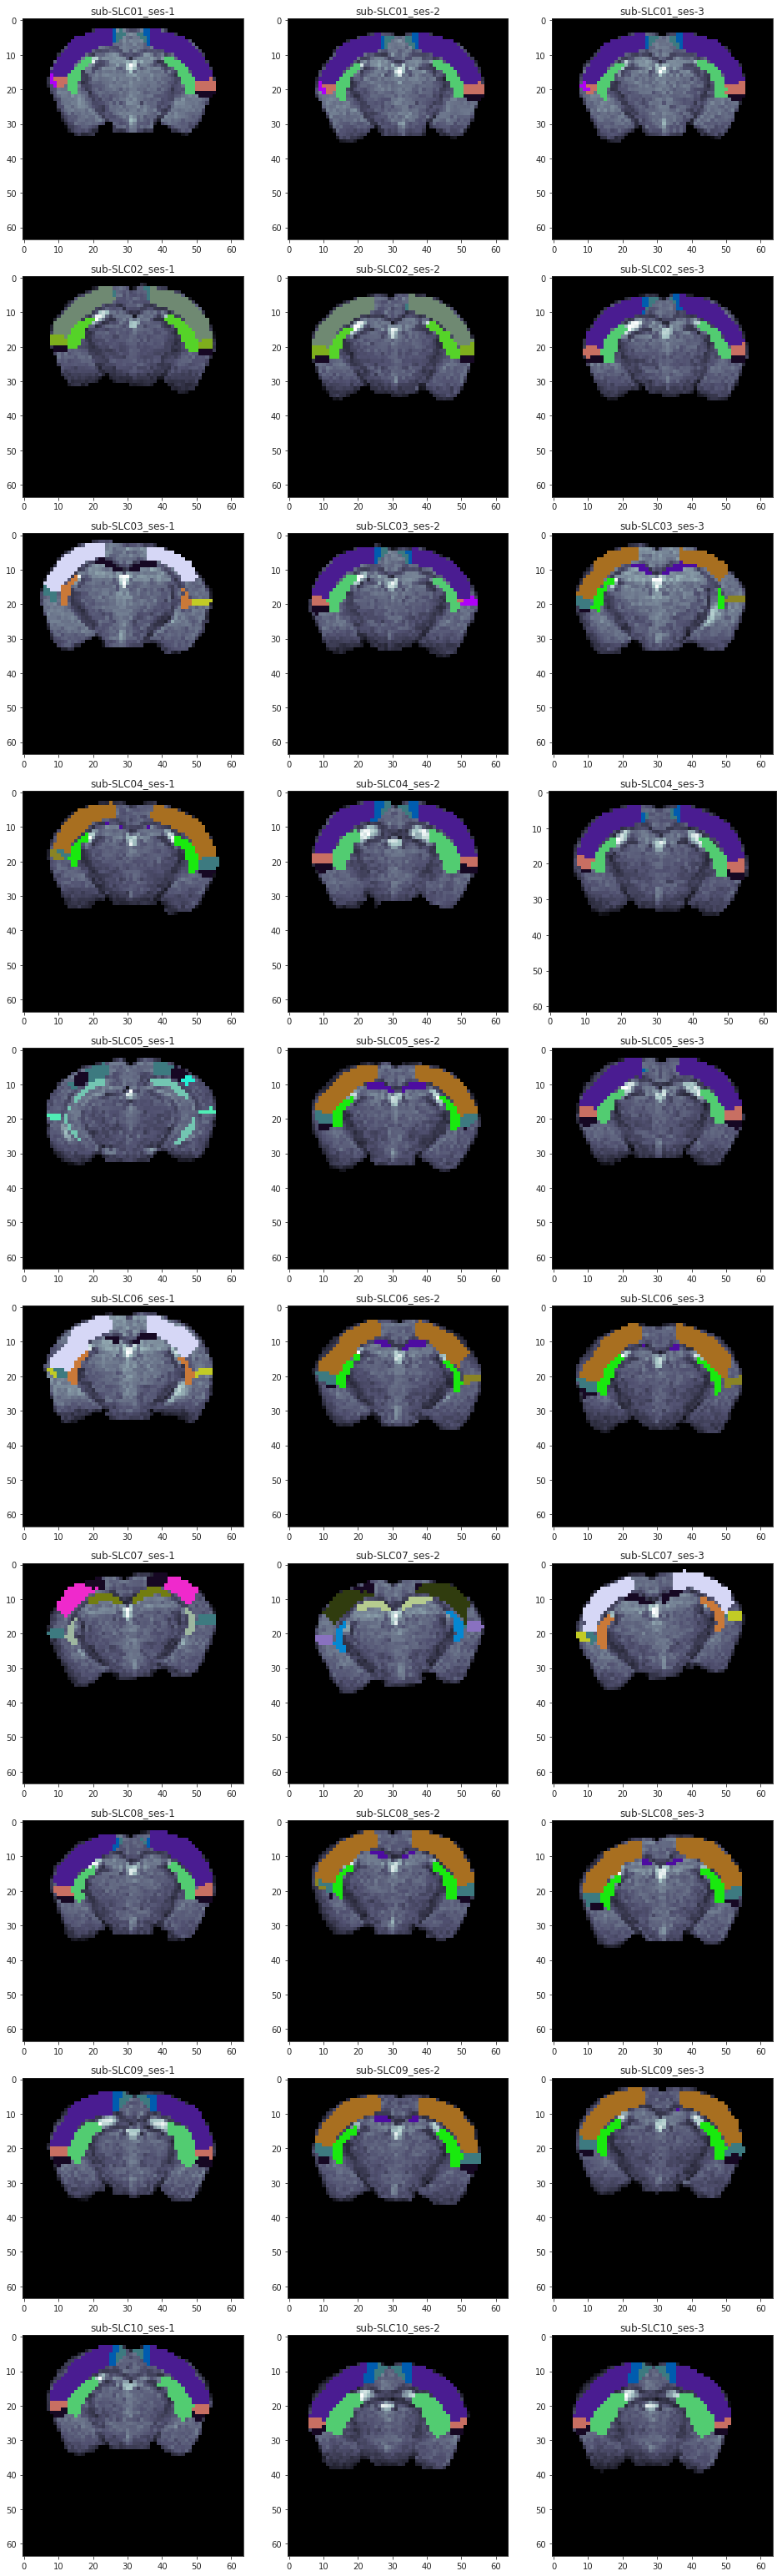

In [23]:
fig, axes = create_figure(10, 3, (13.5, 43))

for ax, (key, obj) in zip(axes.flat, obj_all.items()):
    t = mice.T1w[key].load_ants()
    t *= mice.mask3d[key].load_ants()
    
    ax.imshow(t[..., 40].T, cmap='bone')
    x2plt = np.ma.masked_where(
        obj_all[key]['misc'][..., 40] == 0,
        obj_all[key]['misc'][..., 40]
    )
    ax.imshow(x2plt.T, cmap=cmap)
    ax.set_title(key)
plt.show()

In [24]:
from register.register import Register
reg = Register(mice)

In [27]:
obj_all = reg.register_anat(save_results=True, anchor_ses=2)

100%|██████████| 10/10 [01:12<00:00,  7.24s/it]


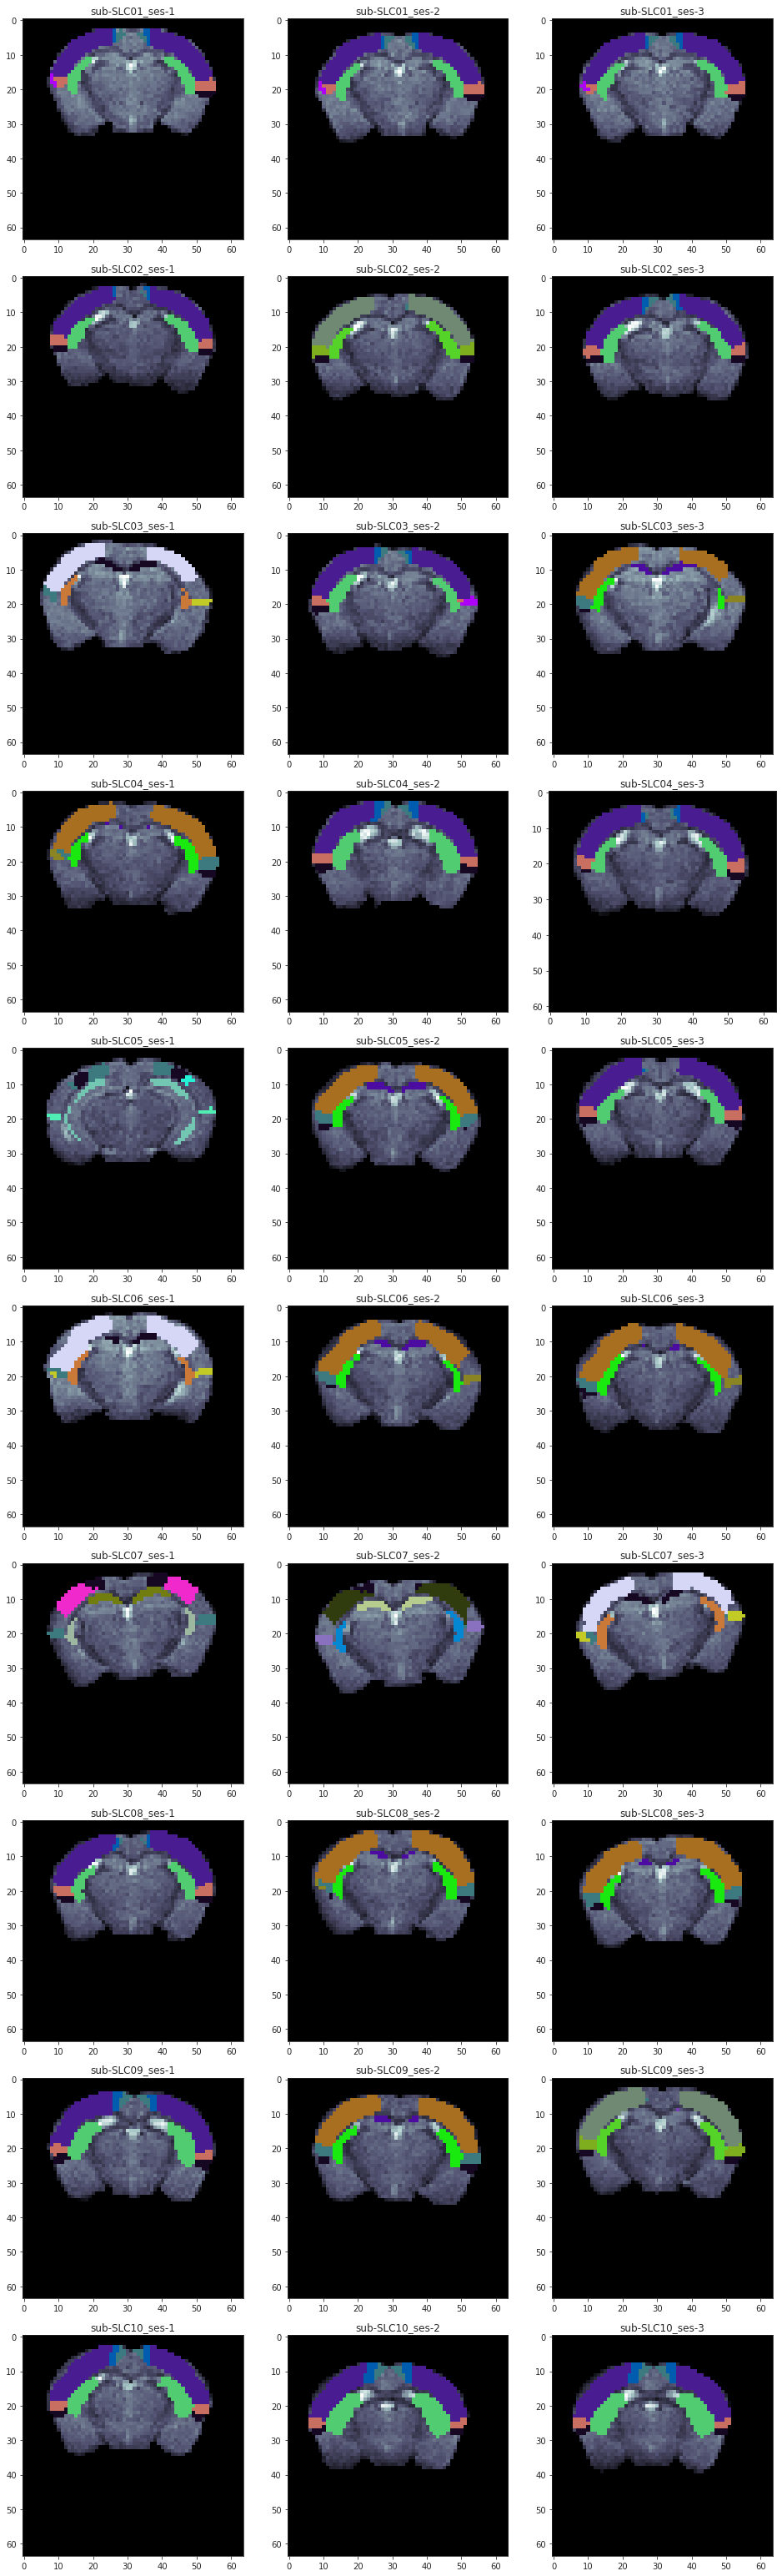

In [28]:
fig, axes = create_figure(10, 3, (13.5, 43))

for ax, (key, obj) in zip(axes.flat, obj_all.items()):
    t = mice.T1w[key].load_ants()
    t *= mice.mask3d[key].load_ants()
    
    ax.imshow(t[..., 40].T, cmap='bone')
    x2plt = np.ma.masked_where(
        obj_all[key]['misc'][..., 40] == 0,
        obj_all[key]['misc'][..., 40]
    )
    ax.imshow(x2plt.T, cmap=cmap)
    ax.set_title(key)
plt.show()

## Make the new plots

In [5]:
obj_files = sorted([
    str(e) for e in
    pathlib.Path(mice.cfg.masks_dir).rglob('*_cortex.nii.gz*')
])

t1ws = {}
objs = {}
for key, anat in mice.T1w.items():
    file = next(
        f for f in obj_files
        if key in f
    )
    obj = ants.image_read(
        pjoin(mice.cfg.masks_dir, file),
        pixeltype='unsigned int',
    )
    m = mice.mask3d[key].load_ants().numpy()
    objs[key], t1ws[key] = filter_boundaries(
        [obj.numpy(), anat.load_ants().numpy()], m)

In [6]:
for key, obj in tqdm(objs.items()):
    save_file = pjoin(tmp_dir, 'ROI_plots_anchor2', f'ROIs_{key}.pdf')
    f1, s1 = _coronal(key, obj, t1ws[key])
    f2, s2 = _sagittal(key, obj, t1ws[key])
    f3, s3 = _axial(key, obj, t1ws[key])
    save_fig(
        fig=[f1, f2, f3],
        sup=[s1, s2, s3],
        save_file=save_file,
        display=False,
        multi=True,
    )

  0%|          | 0/30 [00:00<?, ?it/s]